In [92]:
%run '0.0_init_configuration.ipynb'

### Cross Validation

In [93]:
df = pickle.load(open('./boston_housing_clean.pickle', 'rb'))

df.keys()

df_data = df['dataframe']
df_description = df['description']

df_data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


**Coding this up** 

The Kfold object in Scikit Learn tells the cross validation object (see below) how to split up the data.



In [94]:
# Definimos nuestras variables dependientes e independientes
X = df_data.drop('MEDV', axis=1)
y = df_data.MEDV

In [95]:
#Mezclamos los datos y dividimos en 3 grupos
kf = KFold(shuffle=True, random_state=7208, n_splits=3)

# Prueba de conjuntos o pliegues con KF para las 10 primeras unidades
# KF devuelve los indices de las filas que se debe usar para entrenar y probar

for train_index, test_index in kf.split(X):
    print(f'Train Index: ', train_index[:10], len(train_index))
    print(f'Train Index: ', test_index[:10], len(test_index))
    print(' ')

Train Index:  [ 0  2  3  4  5  8  9 10 11 12] 337
Train Index:  [ 1  6  7 21 22 23 35 37 38 40] 169
 
Train Index:  [ 0  1  3  4  6  7  9 11 13 15] 337
Train Index:  [ 2  5  8 10 12 14 26 27 28 29] 169
 
Train Index:  [ 1  2  5  6  7  8 10 12 14 21] 338
Train Index:  [ 0  3  4  9 11 13 15 16 17 18] 168
 


In [96]:
scores = []
lr = LinearRegression()

# predecir para las 3 folds la r2

for train_index, test_index in kf.split(X):
    X_train, X_test, y_train, y_test = (X.iloc[train_index, :],
                                        X.iloc[test_index, :],
                                        y[train_index],
                                        y[test_index])
    
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    score = r2_score(y_test.values, y_pred)
    scores.append(score)

scores

[0.7073228343551847, 0.6754993058479377, 0.7751555930162422]

(same scores, because for vanilla linear regression with no regularization, scaling actually doesn't matter for performance)

This is getting quite cumbersome!

Very luckily, SciKit Learn has some wonderful functions that handle a lot of this for us.


**Discussion (Part 2):**

Now suppose we want to do the same, but appropriately scaling our data as we go through the folds.

What would the steps be now?

**Coding this up**


In [97]:
scores = []

lr = LinearRegression()
s = StandardScaler()

for train_index, test_index, in kf.split(X):
    X_train, X_test, y_train, y_test = (X.iloc[train_index, :],
                                        X.iloc[test_index, :],
                                        y[train_index],
                                        y[test_index])
    
    X_train_s = s.fit_transform(X_train)
    lr.fit(X_train_s, y_train)
    X_test_s = s.transform(X_test)
    y_pred = lr.predict(X_test_s)
    score = r2_score(y_test.values, y_pred)
    scores.append(score)

scores

[0.7073228343551848, 0.6754993058479384, 0.7751555930162419]

(same scores, because for vanilla linear regression with no regularization, scaling actually doesn't matter for performance)

This is getting quite cumbersome!

Very luckily, SciKit Learn has some wonderful functions that handle a lot of this for us.

**Pipeline and Cross_val_predict**

Pipeline lets you chain together multiple operators on your data that both have a fit method.

In [98]:
s = StandardScaler()
lr = LinearRegression()

# Combine multiple processing steps into a pipeline
estimator = Pipeline([('scaler', s),
                      ('regression', lr)])

cross_val_predict is a function that does K-fold cross validation for us, appropriately fitting and transforming at every step of the way.

In [99]:
kf

KFold(n_splits=3, random_state=7208, shuffle=True)

In [100]:
prediction = cross_val_predict(estimator, X, y, cv=kf)

r2_score(y, prediction)

0.717155200286612

In [101]:
np.mean(scores)

np.float64(0.7193259110731217)

Note that `cross_val_predict` doesn't use the same model for all steps; the predictions for each row are made when that row is in the validation set. We really have the collected results of 3 (i.e. kf.num_splits) different models.

When we are done, `estimator` is still not fitted. If we want to predict on new data, we still have to train our `estimator`.



### Lasso Hyperparametro

Buscamos el mejor alpha (el que da mejor rendimiento) para una regression Lasso, usando validación cruzada y evaluando el R².

In [102]:
# Probamos 10 valores de alpha, desde 0.000000001 hasta 1 usando geomspace
alphas = np.geomspace(1e-9, 1e0, num=10)

scores = []
coefs = []

# The code below tunes alpha hyperparameter for lasso regression

for alpha in alphas:
    las = Lasso(alpha = alpha, max_iter=100000)

    estimator = Pipeline([('sclaer', s),
                          ('lass_regression', las)])
    
    prediction = cross_val_predict(estimator, X , y, cv=kf)

    score = r2_score(y,prediction)
    scores.append(score)

# Nos muestra resultados para cada alpha
list(zip(alphas, scores))


[(np.float64(1e-09), 0.7171552003197053),
 (np.float64(1e-08), 0.7171552006181545),
 (np.float64(1e-07), 0.7171552035925728),
 (np.float64(1e-06), 0.7171552334129103),
 (np.float64(1e-05), 0.7171555294105064),
 (np.float64(0.0001), 0.7171585099392994),
 (np.float64(0.001), 0.7171871457953388),
 (np.float64(0.01), 0.7173967315500526),
 (np.float64(0.1), 0.7128415167346231),
 (np.float64(1.0), 0.6567318068708903)]

Casi todos los coeficientes son diferentes a cero,y además casi todas las variables están siendo usadas.

In [103]:
Lasso(alpha=1e-6).fit(X,y).coef_

array([-1.07170372e-01,  4.63952623e-02,  2.08588308e-02,  2.68854318e+00,
       -1.77954207e+01,  3.80475296e+00,  7.50802707e-04, -1.47575348e+00,
        3.05654279e-01, -1.23293755e-02, -9.53459908e-01,  9.39253013e-03,
       -5.25467196e-01])

Algunos coeficientes son 0 -> Lasso está eliminando variables, lo que nos dice que el modelo esta simplicandose.


In [104]:
Lasso(alpha=1.0).fit(X,y).coef_

array([-0.06342255,  0.04916867, -0.        ,  0.        , -0.        ,
        0.94678567,  0.02092737, -0.66900864,  0.26417501, -0.01520915,
       -0.72319901,  0.00829117, -0.76143296])

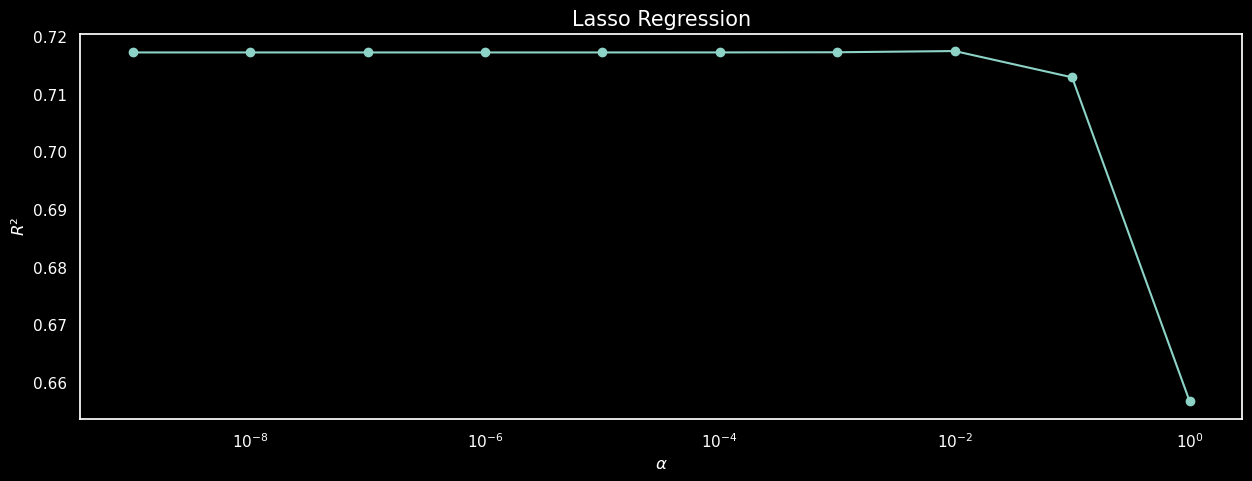

In [105]:
# Graficamos
plt.semilogx(alphas, scores, '-o')
plt.title('Lasso Regression', fontsize=15)
plt.xlabel('$\\alpha$')
plt.ylabel('$R²$')
plt.show()

**Using Polynomial Features**

In [106]:
# Usamos polynomialfeatures para aumentarla capacidad del modelo para patrones mas complejos.
pf = PolynomialFeatures(degree=2)

# Probamos 5 valores de alpha, desde 0.001 hasta 10, distribuidos logaritmicamente.
alphas = np.geomspace(0.001, 10, 5)
scores = []

for alpha in alphas:
    las = Lasso(alpha = alpha, max_iter=100000)
    estimator = Pipeline([('make_higher_degree', pf),
                          ('scaler', s),
                          ('lasso_regression', las)])
    
    predictions = cross_val_predict(estimator, X ,y, cv=kf)
    score = r2_score(y, predictions)
    scores.append(score)

# Nos muestra resultados para cada alpha:
list(zip(alphas, scores))

[(np.float64(0.001), 0.8290117603442988),
 (np.float64(0.01), 0.8523861867314317),
 (np.float64(0.1), 0.7978921415440875),
 (np.float64(1.0), 0.7065601828070518),
 (np.float64(10.0), -0.0007159193061538893)]

- Cuando alpha = 0.01. el modelo logra mejor rendimiento: R² = 0.8524
- Valores muy grandes de alpha como 10 penalizan demasiado al modelo, practicamente no aprende.
- Lasso controla la complejidad, lo cual es esencial al usar polinomias (porque aumente mucho el número de variables)

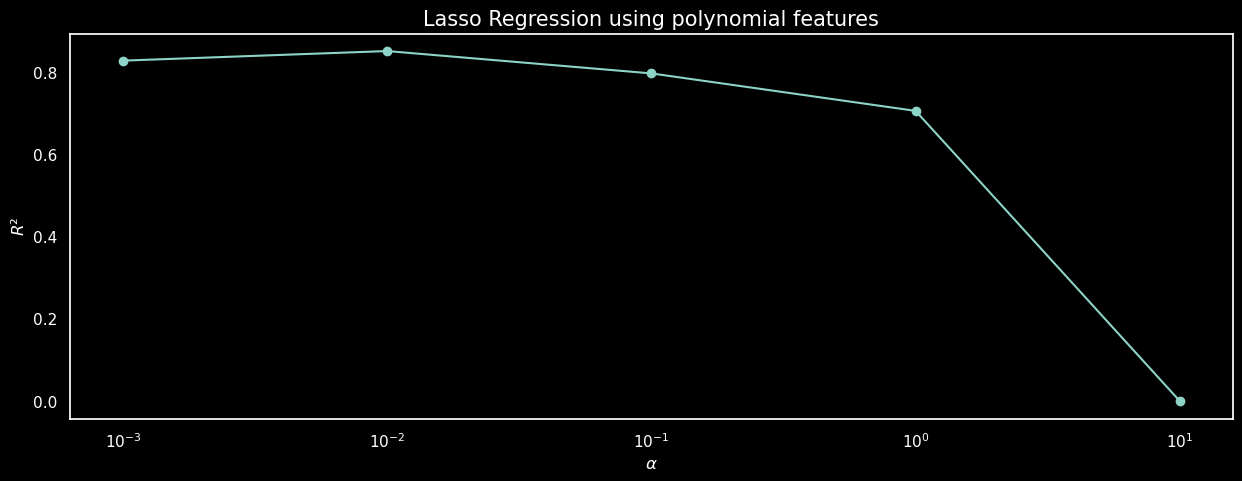

In [107]:
#Graficamos
plt.semilogx(alphas, scores, '-o')
plt.title('Lasso Regression using polynomial features', fontsize=15)
plt.xlabel('$\\alpha$')
plt.ylabel('$R²$')
plt.show()

Ya encontramos que `alpha = 0.01` era el mejor valor con validación cruzada. Ahora entrenamos un modelo final con todos los datos disponibles y ese alpha óptimo



In [108]:
# Once we have found the hyperparameter (alpha 1-e-2 = 0.01)
# Make the model and train it on all the data
# The release it into the wild
best_estimator = Pipeline([('make_higher_degree', PolynomialFeatures(degree=2)),
                           ('scaler', s),
                           ('lasso_regression', Lasso(alpha=0.01, max_iter=100000))])

best_estimator.fit(X,y)
print(f'R² = {best_estimator.score(X,y)}')

R² = 0.9032551408154241


In [109]:
# Otra manera de optimizar el codigo
# from sklearn.linear_model import LassoCV

# best_estimator = Pipeline([
#     ('make_higher_degree', PolynomialFeatures(degree=2)),
#     ('scaler', s),
#     ('lasso_cv', LassoCV(alphas=alphas, max_iter=100000, cv=kf))
# ])

# best_estimator.fit(X, y)
# print(f'Mejor alpha: {best_estimator.named_steps["lasso_cv"].alpha_}')
# print(f'R² final: {best_estimator.score(X, y)}')


Devuelve todos los coeficientes del modelo. Muchos son 0, y eso es justamente el poder de Lasso:

🔥 Elimina automáticamente las variables irrelevantes.

Eso ayuda a que el modelo sea más simple y generalice mejor.

In [110]:
best_estimator.named_steps['lasso_regression'].coef_

array([ 0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        4.61127587e+00,  0.00000000e+00,  6.24240557e-01,  0.00000000e+00,
       -7.22878514e+00,  9.74968793e+00,  0.00000000e+00,  0.00000000e+00,
        6.34548325e-01,  0.00000000e+00,  9.95741679e-01, -5.51374291e-03,
       -0.00000000e+00,  2.44370838e+00, -2.40444044e+00, -0.00000000e+00,
       -0.00000000e+00, -2.23044443e-01, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -2.88128934e-01,  5.17203914e-01,  3.07715719e-01,
       -3.39853933e-01, -9.86590910e-02, -0.00000000e+00,  2.72847487e-01,
       -0.00000000e+00, -6.39829763e-01, -3.16474346e-01,  1.44555554e+00,
        0.00000000e+00, -0.00000000e+00, -8.84630187e-01,  1.32081558e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  2.63148300e+00,
       -2.62941147e-01,  0.00000000e+00,  9.08410143e-01, -8.17144528e-01,
        0.00000000e+00, -4.31628234e+00,  5.53254405e-01, -2.91912598e+00,
       -4.68486241e+00,  

### Regression Ridge
🔹 Lasso (L1): es más sensible, así que necesita alphas pequeños (como 0.01 o 0.001) para no borrar variables importantes.

🔹 Ridge (L2): puede usar alphas más grandes (como 1, 10 o incluso 100), porque no elimina variables, solo reduce sus coeficientes.

Which model, Ridge or Lasso, performs best with its optimal hyperparameters on the Boston dataset?

In [111]:
pf = PolynomialFeatures(degree=2)

# Se prueba 20 valores de aplha entre 4 y 20
alphas = np.geomspace(4,20,20)

scores = []

for alpha in alphas:
    ridge = Ridge(alpha = alpha, max_iter=100000)
    estimator = Pipeline([('PolynomialFeatures', pf),
                          ('scaler', s),
                          ('ridge_regression', ridge)])
    
    predictions = cross_val_predict(estimator, X, y, cv=kf)
    score = r2_score(y, predictions)
    scores.append(score)

# Nos muestra resultados para cada alpha
list(zip(alphas, scores))

[(np.float64(4.0), 0.8484185023768225),
 (np.float64(4.353593602921549), 0.8472722908297783),
 (np.float64(4.7384443148498585), 0.84605780187115),
 (np.float64(5.157315214232582), 0.8447705285265277),
 (np.float64(5.6132136312332355), 0.8434059755297258),
 (np.float64(6.109412739192265), 0.8419597863173682),
 (np.float64(6.649475054738714), 0.8404278779480383),
 (np.float64(7.237278015274221), 0.8388065800508419),
 (np.float64(7.877041817465654), 0.8370927733842062),
 (np.float64(8.573359716616), 0.8352840232099317),
 (np.float64(9.331231004451181), 0.8333787024964523),
 (np.float64(10.156096902090468), 0.8313760999886395),
 (np.float64(11.053879625898109), 0.8292765084384812),
 (np.float64(12.03102490669371), 0.8270812887878123),
 (np.float64(13.094548267592895), 0.8247929068221261),
 (np.float64(14.252085392734966), 0.8224149397493326),
 (np.float64(15.511946948525646), 0.8199520512603051),
 (np.float64(16.88317825098993), 0.8174099348478365),
 (np.float64(18.3756242076235), 0.814795

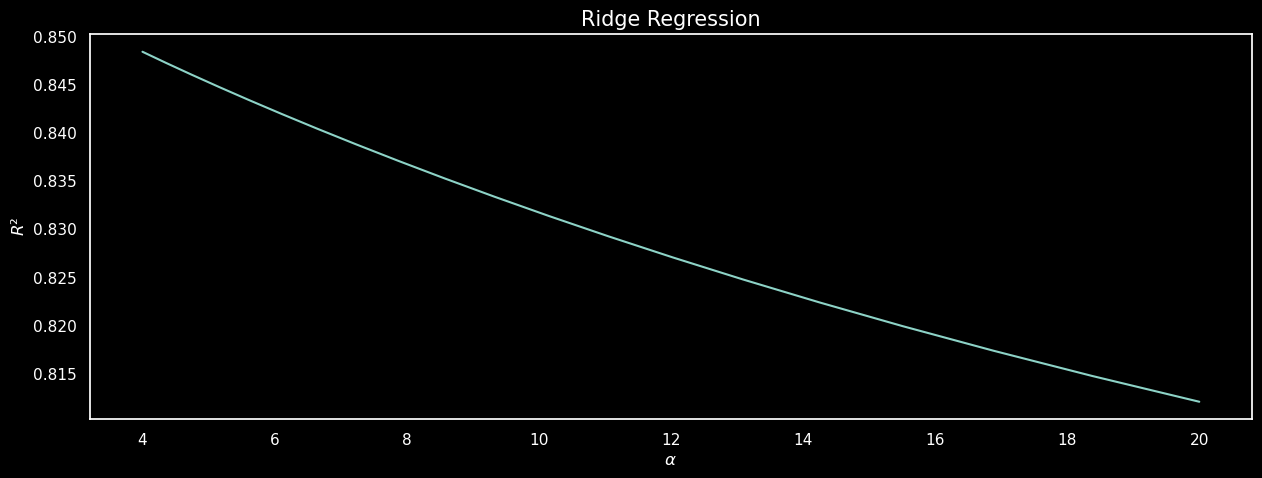

In [112]:
plt.plot(alphas,scores)
plt.title('Ridge Regression', fontsize=15)
plt.xlabel('$\\alpha$')
plt.ylabel('$R²$')
plt.show()

**Conclusion:** Both Lasso and Ridge with proper hyperparameter tuning give better results than plain ol' Linear Regression!

In [113]:
# Once we have found the hyperparameter (alpha~1e-2=0.01)
# make the model and train it on ALL the data
# Then release it into the wild .....
best_estimator = Pipeline([('make_higher_degree', PolynomialFeatures(degree=2)),
                           ('scaler', s),
                           ('ridge_regression', Ridge(alpha=4.0, max_iter=100000))])

best_estimator.fit(X,y)
print(f'R² = {best_estimator.score(X,y)}')

R² = 0.8964707714558111


Ahora queremos saber cuáles combinaciones de variables (o variables al cuadrado) fueron más importantes en la predicción, es decir, qué afecta más al valor predicho.

-`get_feature_names_out()` → nos da los nombres de las variables creadas (como RM^2, RM LSTAT, etc.).

-`.coef_ `→ nos da el peso (coeficiente) de cada variable.

In [114]:
df_importances = pd.DataFrame(zip(best_estimator.named_steps['make_higher_degree'].get_feature_names_out(),
                                  best_estimator.named_steps['ridge_regression'].coef_))

df_importances.sort_values(by=1)

,0,1
73,RM TAX,-3.647230
76,RM LSTAT,-3.454818
74,RM PTRATIO,-2.986537
94,RAD LSTAT,-2.719593
52,CHAS RM,-2.560913
...,...,...
17,CRIM CHAS,2.453963
6,RM,2.635153
9,RAD,2.675497
104,LSTAT^2,4.634553


In [115]:
col_names_dict = dict(zip(list(range(len(X.columns.values))), X.columns.values))
col_names_dict

{0: 'CRIM',
 1: 'ZN',
 2: 'INDUS',
 3: 'CHAS',
 4: 'NOX',
 5: 'RM',
 6: 'AGE',
 7: 'DIS',
 8: 'RAD',
 9: 'TAX',
 10: 'PTRATIO',
 11: 'B',
 12: 'LSTAT'}

### Grid Search CV

To do cross-validation, we used two techniques:

* use KFolds and manually create a loop to do cross-validation
* use cross_val_predict and score to get a cross-valiated score in a couple of lines.

To do hyper-parameter tuning, we see a general pattern:

* use cross_val_predict and score in a manually written loop over hyperparemeters, then select the best one.

Perhaps not surprisingly, there is a function that does this for us -- GridSearchCV

* El mejor modelo usa polinomios de grado 2.

* Y una regularización alpha = 4.7.

* Con eso, se obtuvo un R² de 0.86 en validación cruzada, es decir, explica el 85% de la variación.

In [116]:
estimator = Pipeline([('polynomial_features', PolynomialFeatures()),
                      ('scaler', StandardScaler()),
                      ('ridge_regression', Ridge())])

params = {'polynomial_features__degree': [1,2,3],
          'ridge_regression__alpha': np.geomspace(4,20,20)}

grid = GridSearchCV(estimator, params, cv=kf)
grid.fit(X,y)

print(grid.best_params_)
print(grid.best_score_)
print('\n')
print('Columnas durante el ajuste: ', grid.best_estimator_.named_steps['polynomial_features'].get_feature_names_out())
print('\n')
print(f'Columnas durante la predicción: {X.columns}')

{'polynomial_features__degree': 3, 'ridge_regression__alpha': np.float64(4.7384443148498585)}
0.8624592560397512


Columnas durante el ajuste:  ['1' 'CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX'
 'PTRATIO' 'B' 'LSTAT' 'CRIM^2' 'CRIM ZN' 'CRIM INDUS' 'CRIM CHAS'
 'CRIM NOX' 'CRIM RM' 'CRIM AGE' 'CRIM DIS' 'CRIM RAD' 'CRIM TAX'
 'CRIM PTRATIO' 'CRIM B' 'CRIM LSTAT' 'ZN^2' 'ZN INDUS' 'ZN CHAS' 'ZN NOX'
 'ZN RM' 'ZN AGE' 'ZN DIS' 'ZN RAD' 'ZN TAX' 'ZN PTRATIO' 'ZN B'
 'ZN LSTAT' 'INDUS^2' 'INDUS CHAS' 'INDUS NOX' 'INDUS RM' 'INDUS AGE'
 'INDUS DIS' 'INDUS RAD' 'INDUS TAX' 'INDUS PTRATIO' 'INDUS B'
 'INDUS LSTAT' 'CHAS^2' 'CHAS NOX' 'CHAS RM' 'CHAS AGE' 'CHAS DIS'
 'CHAS RAD' 'CHAS TAX' 'CHAS PTRATIO' 'CHAS B' 'CHAS LSTAT' 'NOX^2'
 'NOX RM' 'NOX AGE' 'NOX DIS' 'NOX RAD' 'NOX TAX' 'NOX PTRATIO' 'NOX B'
 'NOX LSTAT' 'RM^2' 'RM AGE' 'RM DIS' 'RM RAD' 'RM TAX' 'RM PTRATIO'
 'RM B' 'RM LSTAT' 'AGE^2' 'AGE DIS' 'AGE RAD' 'AGE TAX' 'AGE PTRATIO'
 'AGE B' 'AGE LSTAT' 'DIS^2' 'DIS RA

In [117]:
y_predict = grid.predict(X)

# This include both in-sample and out-of-sample
print(f'R² = {r2_score(y,y_predict)}')


R² = 0.9349806002008593


In [118]:
y_pred_test = grid.predict(X_test)
r2_score(y_test, y_pred_test)

0.9529620397156615

In [119]:
# Notice that "grid" is a fit object!
# We can use grid.predict(X_test) to get brand new predictions!
grid.best_estimator_.named_steps['ridge_regression'].coef_

array([ 0.00000000e+00,  7.10642752e-02, -3.94067933e-01, -2.40747096e-01,
        1.05757704e-01,  1.56430364e-01,  2.01219849e+00,  1.00609105e+00,
       -1.23227869e+00,  1.23100956e+00,  2.44633693e-01, -2.82042073e-02,
        7.92026620e-01,  1.49261631e-01,  7.42777765e-02, -7.67680505e-02,
        1.60518250e-01,  9.62567650e-01, -2.18206542e-01,  1.09968700e-01,
       -6.68084136e-02, -2.00864043e-01, -9.03071457e-02,  1.84076699e-02,
        3.48128713e-02,  2.70622454e-01,  1.24754852e-01, -6.31812716e-02,
       -3.15866932e-01, -2.55345731e-02, -1.86387862e-01,  2.74656114e-02,
       -1.35438230e-01, -2.77781497e-01, -9.17960312e-02, -1.42126834e-01,
       -7.94448295e-02, -2.47417278e-01, -4.53207406e-01,  3.24127067e-01,
       -6.37660601e-02, -1.87045955e-02,  1.11913822e-02,  3.02656343e-01,
       -1.00638431e+00,  6.31972538e-01,  5.96821908e-01, -3.26916364e-01,
        1.89993312e-01, -7.32188863e-01,  1.05757704e-01, -6.02199027e-02,
       -1.33256865e-01,  